# Present Value and Discounting
## From Compound Interest to NPV to Bond Pricing to Yield Curves

A staged guide that builds the entire machinery of discounting from one simple idea:
**a dollar today is worth more than a dollar tomorrow.**

We start with compound interest (something you already know), then derive every major
concept in fixed-income finance — present value, NPV, bond pricing, and yield curves —
as natural consequences of that single principle.

| Stage | Topic |
|-------|-------|
| 0 | The problem: why timing of money matters |
| 1 | Compound interest — the engine of growth |
| 2 | Discounting — compound interest in reverse |
| 3 | Present value of a single cash flow |
| 4 | Present value of multiple cash flows (NPV) |
| 5 | Net present value for investment decisions |
| 6 | Bond pricing — NPV applied to debt |
| 7 | Yield to maturity — the bond's implied rate |
| 8 | The yield curve — rates across maturities |
| 9 | Spot rates and bootstrapping |
| 10 | Duration and interest rate sensitivity |
| 11 | Putting it all together — a mini bond analytics engine |
| 12 | Key takeaways and practice exercises |

---
## Stage 0 — The Problem: Why Timing of Money Matters

### Motivation

Suppose someone offers you two deals:
- **Deal A:** Receive $1,000 today.
- **Deal B:** Receive $1,000 one year from now.

Which is better? Everyone intuitively picks Deal A, but *why*? And by *how much* is it better?

Without a framework to answer "how much," we can't compare:
- An investment that pays $500 now vs. $600 in two years
- A bond that pays $30 every six months for 10 years
- Two projects with completely different cash flow timing

### Intuition

Think of money like a seed. A seed you plant today grows into a tree. A seed someone promises
to give you next year means you lose a year of growth. The question is: **how big is the tree
after that lost year?** That depends on the growth rate — the interest rate.

In [1]:
# Stage 0: The core problem — same dollar amount, different timing
# Which deal is better, and by how much?

deal_a = 1000  # receive today
deal_b = 1000  # receive in 1 year
annual_rate = 0.05  # 5% — what you could earn if you had the money today

# If you take Deal A and invest it for 1 year:
deal_a_future = deal_a * (1 + annual_rate)

print(f"Deal A: ${deal_a:,.2f} today")
print(f"  -> If invested at {annual_rate:.0%} for 1 year: ${deal_a_future:,.2f}")
print(f"Deal B: ${deal_b:,.2f} in 1 year")
print(f"")
print(f"Deal A is worth ${deal_a_future - deal_b:,.2f} MORE than Deal B")
print(f"(That's the opportunity cost of waiting)")

Deal A: $1,000.00 today
  -> If invested at 5% for 1 year: $1,050.00
Deal B: $1,000.00 in 1 year

Deal A is worth $50.00 MORE than Deal B
(That's the opportunity cost of waiting)


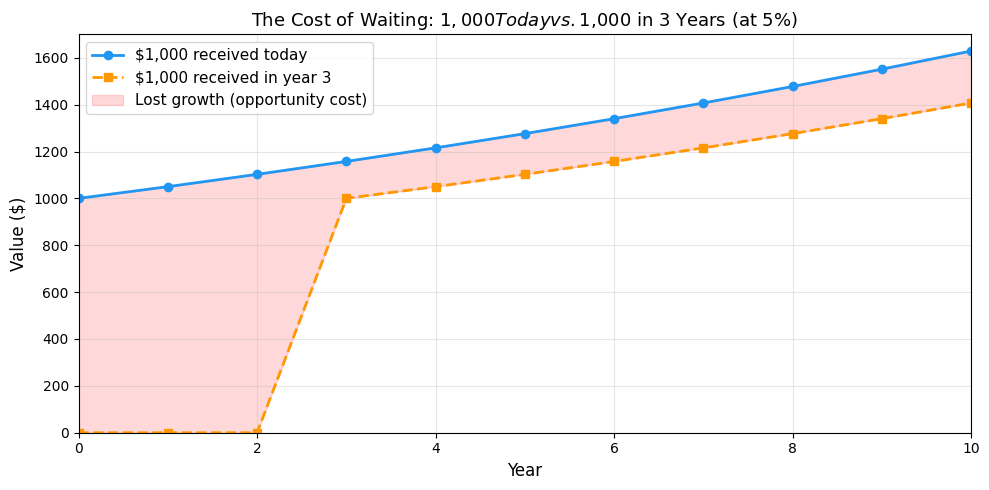

By year 10, the gap is $221.79 — that's the price of a 3-year delay.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize: the opportunity cost of waiting
years = list(range(0, 11))
rate = 0.05

# $1000 received today, growing each year
value_if_received_today = [1000 * (1 + rate) ** t for t in years]
# $1000 received in year 3, then growing
delay = 3
value_if_received_later = [0 if t < delay else 1000 * (1 + rate) ** (t - delay) for t in years]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(years, value_if_received_today, 'o-', color='#2196F3', linewidth=2, label='$1,000 received today')
ax.plot(years, value_if_received_later, 's--', color='#FF9800', linewidth=2, label=f'$1,000 received in year {delay}')

# Shade the gap
ax.fill_between(years, value_if_received_later, value_if_received_today,
                alpha=0.15, color='red', label='Lost growth (opportunity cost)')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Value ($)', fontsize=12)
ax.set_title('The Cost of Waiting: $1,000 Today vs. $1,000 in 3 Years (at 5%)', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 10)
ax.set_ylim(0, 1700)
plt.tight_layout()
plt.show()

gap_at_10 = value_if_received_today[10] - value_if_received_later[10]
print(f"By year 10, the gap is ${gap_at_10:,.2f} — that's the price of a 3-year delay.")

---
## Stage 1 — Compound Interest: The Engine of Growth

### Motivation

Before we can discount (go backwards from future to present), we need to fully understand
compounding (going forward from present to future). Compounding is the foundation everything
else rests on.

### Intuition

Simple interest is like earning wages — you get paid on your original amount only.
Compound interest is like earning *interest on your interest* — your money breeds more money,
and *that* money breeds even more.

The formula: **FV = PV × (1 + r)^n**

- `PV` = present value (what you start with)
- `r` = interest rate per period
- `n` = number of periods
- `FV` = future value (what you end with)

In [3]:
# Stage 1: Compound vs. simple interest — see the difference

principal = 1000
rate = 0.08  # 8% annual
years = 30

print(f"Starting amount: ${principal:,.2f}")
print(f"Annual rate: {rate:.0%}")
print(f"")
print(f"{'Year':>5} {'Simple':>12} {'Compound':>12} {'Difference':>12}")
print("-" * 45)

for y in [1, 5, 10, 15, 20, 25, 30]:
    simple = principal * (1 + rate * y)             # linear growth
    compound = principal * (1 + rate) ** y           # exponential growth
    diff = compound - simple
    print(f"{y:>5} ${simple:>10,.2f} ${compound:>10,.2f} ${diff:>10,.2f}")

print(f"\nAfter {years} years, compounding gives you", end=" ")
ratio = (principal * (1 + rate) ** years) / (principal * (1 + rate * years))
print(f"{ratio:.1f}x what simple interest gives.")

Starting amount: $1,000.00
Annual rate: 8%

 Year       Simple     Compound   Difference
---------------------------------------------
    1 $  1,080.00 $  1,080.00 $      0.00
    5 $  1,400.00 $  1,469.33 $     69.33
   10 $  1,800.00 $  2,158.92 $    358.92
   15 $  2,200.00 $  3,172.17 $    972.17
   20 $  2,600.00 $  4,660.96 $  2,060.96
   25 $  3,000.00 $  6,848.48 $  3,848.48
   30 $  3,400.00 $ 10,062.66 $  6,662.66

After 30 years, compounding gives you 3.0x what simple interest gives.


In [4]:
# What about compounding frequency? Annual vs. semi-annual vs. continuous

import math

principal = 1000
annual_rate = 0.10  # 10% nominal
years = 10

frequencies = [
    ("Annual",       1),
    ("Semi-annual",  2),
    ("Quarterly",    4),
    ("Monthly",     12),
    ("Daily",      365),
]

print(f"${principal:,} at {annual_rate:.0%} nominal rate for {years} years\n")
print(f"{'Frequency':<15} {'Periods':>8} {'Rate/Period':>12} {'Future Value':>14}")
print("-" * 52)

for name, m in frequencies:
    fv = principal * (1 + annual_rate / m) ** (m * years)
    print(f"{name:<15} {m * years:>8} {annual_rate / m:>11.6f} ${fv:>12,.2f}")

# Continuous compounding: the limit as m -> infinity
fv_continuous = principal * math.exp(annual_rate * years)
print(f"{'Continuous':<15} {'inf':>8} {'->0':>12} ${fv_continuous:>12,.2f}")

print(f"\nThe gap between annual and continuous is only "
      f"${fv_continuous - principal * (1 + annual_rate) ** years:,.2f}")
print("Compounding frequency matters, but with diminishing returns.")

$1,000 at 10% nominal rate for 10 years

Frequency        Periods  Rate/Period   Future Value
----------------------------------------------------
Annual                10    0.100000 $    2,593.74
Semi-annual           20    0.050000 $    2,653.30
Quarterly             40    0.025000 $    2,685.06
Monthly              120    0.008333 $    2,707.04
Daily               3650    0.000274 $    2,717.91
Continuous           inf          ->0 $    2,718.28

The gap between annual and continuous is only $124.54
Compounding frequency matters, but with diminishing returns.


---
## Stage 2 — Discounting: Compound Interest in Reverse

### Motivation

Compounding answers: *"If I have $X today, what will it be worth in the future?"*

But most real-world problems go the other direction: *"If I'll receive $X in the future,
what is it worth today?"* This reverse operation is **discounting**.

### Intuition

If compounding is like fast-forwarding a video, discounting is rewinding. The same formula,
just rearranged:

- Compounding: **FV = PV × (1 + r)^n** (multiply to go forward)
- Discounting: **PV = FV / (1 + r)^n** (divide to go back)

The term **1 / (1 + r)^n** is called the **discount factor** — it tells you how many
cents a future dollar is worth today.

In [5]:
# Stage 2: Discount factors — the exchange rate between future and present dollars

rate = 0.05

print(f"Discount factors at r = {rate:.0%}")
print(f"(How much $1 received in year N is worth today)\n")
print(f"{'Year':>5} {'Discount Factor':>16} {'$1 Future = $? Today':>22}")
print("-" * 46)

for n in range(0, 11):
    df = 1 / (1 + rate) ** n
    print(f"{n:>5} {df:>16.6f} ${df:>20.4f}")

# Verify: discounting is the exact inverse of compounding
pv = 1000
n = 10
fv = pv * (1 + rate) ** n
pv_back = fv / (1 + rate) ** n

print(f"\nVerification (round-trip):")
print(f"  Start: ${pv:,.2f}")
print(f"  Compound forward {n} years: ${fv:,.2f}")
print(f"  Discount back {n} years:    ${pv_back:,.2f}")
assert abs(pv - pv_back) < 1e-10, "Round-trip failed!"
print(f"  Round-trip matches perfectly.")

Discount factors at r = 5%
(How much $1 received in year N is worth today)

 Year  Discount Factor   $1 Future = $? Today
----------------------------------------------
    0         1.000000 $              1.0000
    1         0.952381 $              0.9524
    2         0.907029 $              0.9070
    3         0.863838 $              0.8638
    4         0.822702 $              0.8227
    5         0.783526 $              0.7835
    6         0.746215 $              0.7462
    7         0.710681 $              0.7107
    8         0.676839 $              0.6768
    9         0.644609 $              0.6446
   10         0.613913 $              0.6139

Verification (round-trip):
  Start: $1,000.00
  Compound forward 10 years: $1,628.89
  Discount back 10 years:    $1,000.00
  Round-trip matches perfectly.


---
## Stage 3 — Present Value of a Single Cash Flow

### Motivation

Now we can answer the real question: *"How much should I pay today for a promise of $X
in N years?"* This is the **present value** (PV) — the cornerstone of all of finance.

### Intuition

Think of present value as the "fair price" of a future payment. If someone promises you
$1,000 in 5 years and the prevailing interest rate is 5%, then PV tells you the exact amount
that, if invested at 5%, would grow to exactly $1,000 in 5 years. That's the price at which
you're indifferent between having the cash now vs. the promise later.

In [6]:
# Stage 3: Present value — the fair price of a future payment

def present_value(future_value, rate, periods):
    """Calculate the present value of a single future cash flow."""
    return future_value / (1 + rate) ** periods

# Example: What's $10,000 received in 7 years worth today at 6%?
fv = 10_000
r = 0.06
n = 7
pv = present_value(fv, r, n)

print(f"Future value: ${fv:>10,.2f} (received in {n} years)")
print(f"Discount rate: {r:.0%}")
print(f"Present value: ${pv:>10,.2f}")
print(f"")
print(f"Interpretation: You'd need to invest ${pv:,.2f} today at {r:.0%}")
print(f"to have exactly ${fv:,.2f} in {n} years.")

# Verify
assert abs(pv * (1 + r) ** n - fv) < 0.01
print(f"\nVerification: ${pv:,.2f} x (1.06)^7 = ${pv * (1 + r) ** n:,.2f} ✓")

Future value: $ 10,000.00 (received in 7 years)
Discount rate: 6%
Present value: $  6,650.57

Interpretation: You'd need to invest $6,650.57 today at 6%
to have exactly $10,000.00 in 7 years.

Verification: $6,650.57 x (1.06)^7 = $10,000.00 ✓


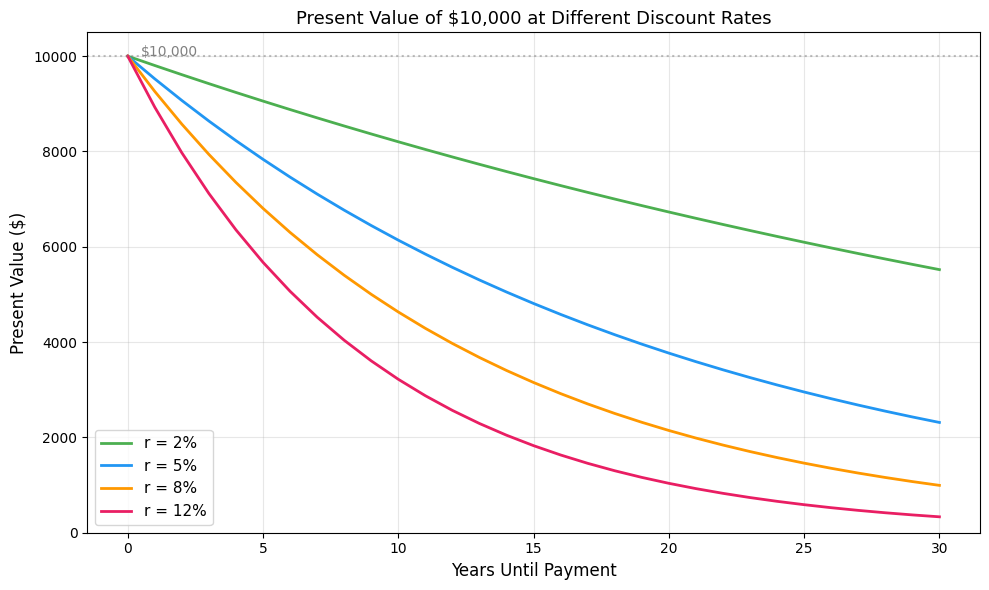

Key insight: higher rates and longer horizons crush present value.
  $10,000 in 30 years at 2%: $5,520.71
  $10,000 in 30 years at 12%: $  333.78
  That's a 16.5x difference!


In [7]:
# How sensitive is PV to the rate and time horizon?

fv = 10_000
rates = [0.02, 0.05, 0.08, 0.12]
max_years = 30

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#4CAF50', '#2196F3', '#FF9800', '#E91E63']

for rate, color in zip(rates, colors):
    years_range = np.arange(0, max_years + 1)
    pvs = [present_value(fv, rate, y) for y in years_range]
    ax.plot(years_range, pvs, '-', color=color, linewidth=2, label=f'r = {rate:.0%}')

ax.set_xlabel('Years Until Payment', fontsize=12)
ax.set_ylabel('Present Value ($)', fontsize=12)
ax.set_title(f'Present Value of ${fv:,} at Different Discount Rates', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, fv * 1.05)
ax.axhline(y=fv, color='gray', linestyle=':', alpha=0.5)
ax.annotate(f'${fv:,}', xy=(0.5, fv), fontsize=10, color='gray')
plt.tight_layout()
plt.show()

print("Key insight: higher rates and longer horizons crush present value.")
print(f"  $10,000 in 30 years at 2%: ${present_value(fv, 0.02, 30):>8,.2f}")
print(f"  $10,000 in 30 years at 12%: ${present_value(fv, 0.12, 30):>8,.2f}")
print(f"  That's a {present_value(fv, 0.02, 30) / present_value(fv, 0.12, 30):.1f}x difference!")

---
## Stage 4 — Present Value of Multiple Cash Flows (NPV)

### Motivation

Real-world payments aren't a single lump sum. A job pays you monthly. A bond pays coupons
semi-annually. A business generates cash flows every year. We need to handle *streams* of
cash flows, each arriving at a different time.

### Intuition

Since present value is additive (the PV of getting $100 in year 1 AND $200 in year 2 is just
PV($100, 1) + PV($200, 2)), we can handle any stream of cash flows by discounting each one
individually and adding them up.

**NPV = sum of PV(cash_flow_t) for each time t**

In [8]:
# Stage 4: NPV — discount each cash flow, then sum

def npv(rate, cash_flows):
    """Calculate Net Present Value of a series of cash flows.
    
    cash_flows: list of (time, amount) tuples
    rate: discount rate per period
    """
    total = 0.0
    for t, cf in cash_flows:
        pv = cf / (1 + rate) ** t
        total += pv
    return total

# Example: A machine costs $5,000 today and produces $1,500/year for 5 years
cash_flows = [
    (0, -5000),   # initial investment (negative = cost)
    (1,  1500),
    (2,  1500),
    (3,  1500),
    (4,  1500),
    (5,  1500),
]

rate = 0.08

print(f"Machine investment analysis (discount rate = {rate:.0%})\n")
print(f"{'Year':>5} {'Cash Flow':>12} {'Discount Factor':>16} {'Present Value':>14}")
print("-" * 50)

running_npv = 0.0
for t, cf in cash_flows:
    df = 1 / (1 + rate) ** t
    pv = cf * df
    running_npv += pv
    print(f"{t:>5} ${cf:>10,.2f} {df:>16.6f} ${pv:>12,.2f}")

result = npv(rate, cash_flows)
print(f"{'':>5} {'':>12} {'':>16} {'─' * 14}")
print(f"{'':>5} {'NPV':>12} {'':>16} ${result:>12,.2f}")
print(f"\nNPV = ${result:,.2f} > 0 → The investment creates value.")
print(f"You'd be ${result:,.2f} richer (in today's dollars) by taking this deal.")

Machine investment analysis (discount rate = 8%)

 Year    Cash Flow  Discount Factor  Present Value
--------------------------------------------------
    0 $ -5,000.00         1.000000 $   -5,000.00
    1 $  1,500.00         0.925926 $    1,388.89
    2 $  1,500.00         0.857339 $    1,286.01
    3 $  1,500.00         0.793832 $    1,190.75
    4 $  1,500.00         0.735030 $    1,102.54
    5 $  1,500.00         0.680583 $    1,020.87
                                    ──────────────
               NPV                  $      989.07

NPV = $989.07 > 0 → The investment creates value.
You'd be $989.07 richer (in today's dollars) by taking this deal.


---
## Stage 5 — NPV for Investment Decisions

### Motivation

NPV isn't just a number — it's a **decision rule**. NPV > 0 means "take the deal."
NPV < 0 means "walk away." But what if the NPV depends on your discount rate?
What rate makes NPV exactly zero? That's the **Internal Rate of Return (IRR)** — the
breakeven rate that tells you how robust your investment is.

### Intuition

Think of the discount rate as your "hurdle" — the minimum return you demand. The IRR
tells you the actual return the project offers. If IRR > hurdle, you're beating your
minimum; if IRR < hurdle, you're not.

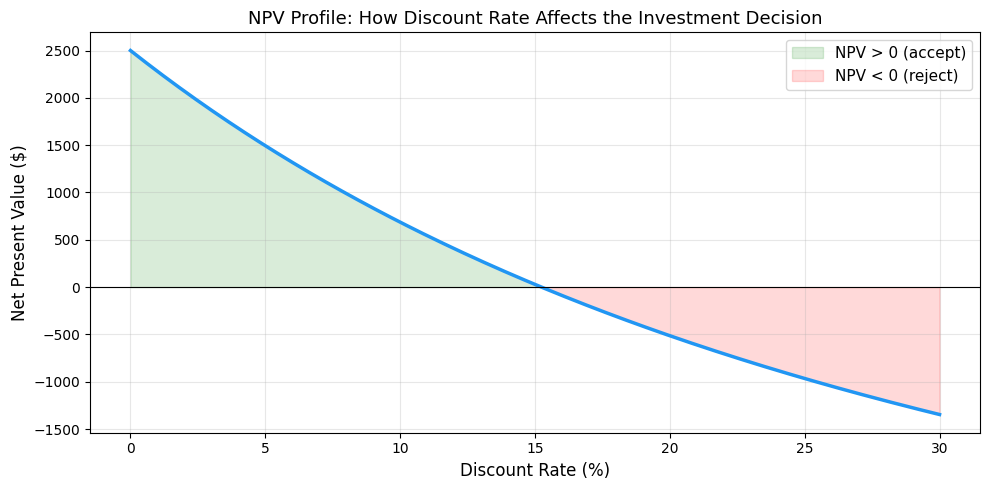

In [9]:
# Stage 5: NPV as a function of the discount rate — finding the IRR

# Same machine: -$5000 today, +$1500/year for 5 years
cash_flows = [(0, -5000)] + [(t, 1500) for t in range(1, 6)]

# Plot NPV across a range of discount rates
rates = np.linspace(0.0, 0.30, 200)
npvs = [npv(r, cash_flows) for r in rates]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(rates * 100, npvs, '-', color='#2196F3', linewidth=2.5)
ax.axhline(y=0, color='black', linewidth=0.8)
ax.fill_between(rates * 100, npvs, 0, where=[n > 0 for n in npvs],
                alpha=0.15, color='green', label='NPV > 0 (accept)')
ax.fill_between(rates * 100, npvs, 0, where=[n < 0 for n in npvs],
                alpha=0.15, color='red', label='NPV < 0 (reject)')

ax.set_xlabel('Discount Rate (%)', fontsize=12)
ax.set_ylabel('Net Present Value ($)', fontsize=12)
ax.set_title('NPV Profile: How Discount Rate Affects the Investment Decision', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Find the IRR using bisection (no scipy needed — build it ourselves)

def irr_bisection(cash_flows, tol=1e-8, max_iter=100):
    """Find the Internal Rate of Return using bisection.
    
    The IRR is the discount rate where NPV = 0.
    """
    lo, hi = -0.5, 5.0  # search range
    
    # NPV at lo should be positive, at hi should be negative
    # (for a standard investment: outflow first, then inflows)
    for i in range(max_iter):
        mid = (lo + hi) / 2
        val = npv(mid, cash_flows)
        if abs(val) < tol:
            return mid, i + 1
        if val > 0:
            lo = mid
        else:
            hi = mid
    return mid, max_iter

cash_flows = [(0, -5000)] + [(t, 1500) for t in range(1, 6)]
irr, iterations = irr_bisection(cash_flows)

print(f"Cash flows: invest $5,000, receive $1,500/year for 5 years")
print(f"IRR = {irr:.4%} (found in {iterations} iterations)")
print(f"NPV at IRR = ${npv(irr, cash_flows):.6f} (essentially zero)")
print(f"")
print(f"Decision rule:")
print(f"  If your hurdle rate < {irr:.2%} → NPV > 0 → Accept")
print(f"  If your hurdle rate > {irr:.2%} → NPV < 0 → Reject")
print(f"")

# Compare two investments
project_a = [(0, -5000)] + [(t, 1500) for t in range(1, 6)]
project_b = [(0, -5000)] + [(t, 1000) for t in range(1, 8)]

irr_a, _ = irr_bisection(project_a)
irr_b, _ = irr_bisection(project_b)

hurdle = 0.08
print(f"Comparing two projects (hurdle rate = {hurdle:.0%}):")
print(f"  Project A: -$5K, +$1.5K/yr x 5yrs → IRR = {irr_a:.2%}, NPV@{hurdle:.0%} = ${npv(hurdle, project_a):,.2f}")
print(f"  Project B: -$5K, +$1.0K/yr x 7yrs → IRR = {irr_b:.2%}, NPV@{hurdle:.0%} = ${npv(hurdle, project_b):,.2f}")

Cash flows: invest $5,000, receive $1,500/year for 5 years
IRR = 15.2382% (found in 41 iterations)
NPV at IRR = $-0.000000 (essentially zero)

Decision rule:
  If your hurdle rate < 15.24% → NPV > 0 → Accept
  If your hurdle rate > 15.24% → NPV < 0 → Reject

Comparing two projects (hurdle rate = 8%):
  Project A: -$5K, +$1.5K/yr x 5yrs → IRR = 15.24%, NPV@8% = $989.07
  Project B: -$5K, +$1.0K/yr x 7yrs → IRR = 9.20%, NPV@8% = $206.37


---
## Stage 6 — Bond Pricing: NPV Applied to Debt

### Motivation

A bond is just a structured stream of cash flows: periodic coupon payments plus the face
value returned at maturity. Bond pricing is literally just NPV with a specific cash flow
pattern.

### Intuition

Think of buying a bond as lending money. You pay the bond price today (like making a loan).
In return, you get regular interest payments (coupons) and your principal back at the end.
The bond price is the PV of all those future payments at the market interest rate.

Key terms:
- **Face value (par):** The amount repaid at maturity (usually $1,000)
- **Coupon rate:** The annual interest rate on the face value
- **Yield (discount rate):** The market's required return

In [11]:
# Stage 6: Bond pricing from first principles

def price_bond(face_value, coupon_rate, yield_rate, years, freq=2):
    """Price a bond using NPV.
    
    face_value: par value ($1000 typically)
    coupon_rate: annual coupon rate
    yield_rate: annual yield (discount rate)
    years: years to maturity
    freq: coupon payments per year (2 = semi-annual)
    
    Returns: bond price
    """
    n_periods = int(years * freq)
    coupon = face_value * coupon_rate / freq  # coupon per period
    y = yield_rate / freq                     # yield per period
    
    price = 0.0
    for t in range(1, n_periods + 1):
        price += coupon / (1 + y) ** t          # PV of each coupon
    price += face_value / (1 + y) ** n_periods  # PV of face value
    
    return price

# Example: 10-year bond, 5% coupon, semi-annual payments
face = 1000
coupon_rate = 0.05
years = 10

print(f"Bond: ${face:,} face, {coupon_rate:.0%} coupon, {years}-year, semi-annual\n")
print(f"{'Market Yield':>13} {'Bond Price':>12} {'vs. Par':>10}")
print("-" * 38)

for y in [0.03, 0.04, 0.05, 0.06, 0.07, 0.08]:
    p = price_bond(face, coupon_rate, y, years)
    vs_par = "at par" if abs(p - face) < 0.01 else ("premium" if p > face else "discount")
    print(f"{y:>12.0%} ${p:>10,.2f} {vs_par:>10}")

print(f"\nKey insight: When yield = coupon rate, price = par (face value).")
print(f"When yield > coupon → price < par (discount bond).")
print(f"When yield < coupon → price > par (premium bond).")

Bond: $1,000 face, 5% coupon, 10-year, semi-annual

 Market Yield   Bond Price    vs. Par
--------------------------------------
          3% $  1,171.69    premium
          4% $  1,081.76    premium
          5% $  1,000.00     at par
          6% $    925.61   discount
          7% $    857.88   discount
          8% $    796.15   discount

Key insight: When yield = coupon rate, price = par (face value).
When yield > coupon → price < par (discount bond).
When yield < coupon → price > par (premium bond).


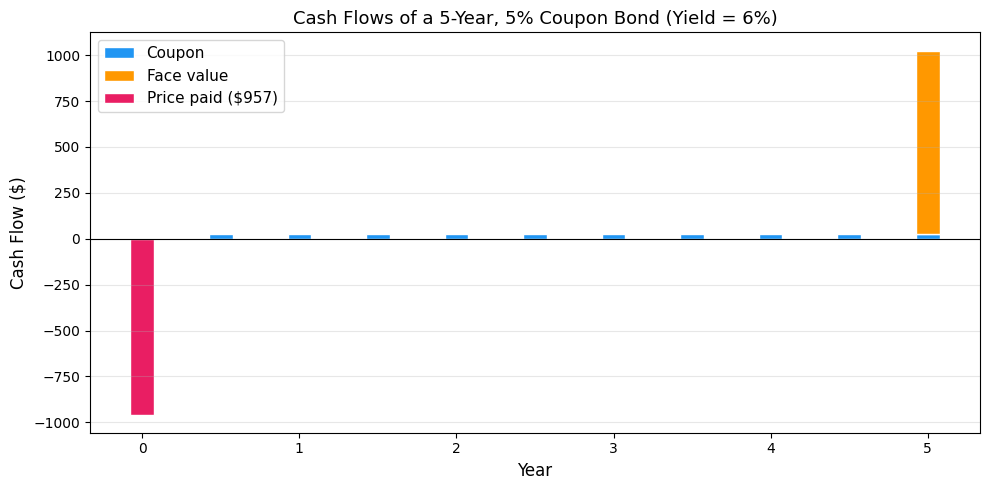

You pay $957.35 today and receive:
  10 coupon payments of $25.00 each = $250.00
  Plus $1,000 face value at maturity
  Total received: $1,250.00
  Total profit: $292.65


In [12]:
# Show the cash flows of a bond visually

face = 1000
coupon_rate = 0.05
years = 5
freq = 2
n_periods = years * freq
coupon = face * coupon_rate / freq

times = [t / freq for t in range(1, n_periods + 1)]
cfs = [coupon] * (n_periods - 1) + [coupon + face]  # last period gets coupon + face

fig, ax = plt.subplots(figsize=(10, 5))

# Plot coupon payments
for t, cf in zip(times, cfs):
    if cf < face:
        ax.bar(t, cf, width=0.15, color='#2196F3', edgecolor='white')
    else:
        ax.bar(t, coupon, width=0.15, color='#2196F3', edgecolor='white',
               label='Coupon' if t == times[-1] else '')
        ax.bar(t, face, width=0.15, bottom=coupon, color='#FF9800', edgecolor='white',
               label='Face value')

# Price (what you pay)
yield_rate = 0.06
bond_price = price_bond(face, coupon_rate, yield_rate, years)
ax.bar(0, -bond_price, width=0.15, color='#E91E63', edgecolor='white', label=f'Price paid (${bond_price:,.0f})')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cash Flow ($)', fontsize=12)
ax.set_title(f'Cash Flows of a {years}-Year, {coupon_rate:.0%} Coupon Bond (Yield = {yield_rate:.0%})', fontsize=13)
ax.axhline(y=0, color='black', linewidth=0.8)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"You pay ${bond_price:,.2f} today and receive:")
print(f"  {n_periods} coupon payments of ${coupon:,.2f} each = ${coupon * n_periods:,.2f}")
print(f"  Plus ${face:,} face value at maturity")
print(f"  Total received: ${coupon * n_periods + face:,.2f}")
print(f"  Total profit: ${coupon * n_periods + face - bond_price:,.2f}")

---
## Stage 7 — Yield to Maturity: The Bond's Implied Rate

### Motivation

So far we've priced bonds *given* a yield. But in practice, you observe the *price* in the
market and need to figure out the *yield*. This is the inverse problem: given the price,
what discount rate was used? That rate is the **Yield to Maturity (YTM)**.

### Intuition

YTM is to bonds what IRR is to projects — it's the discount rate that makes the NPV of all
bond cash flows equal to the market price. It answers: *"If I buy this bond at this price
and hold to maturity, what's my annualized return?"*

In [13]:
# Stage 7: Find YTM using bisection — same idea as IRR

def ytm_bisection(price, face_value, coupon_rate, years, freq=2, tol=1e-10, max_iter=200):
    """Find Yield to Maturity given a bond price."""
    lo, hi = 0.0001, 1.0  # yield search range
    
    for i in range(max_iter):
        mid = (lo + hi) / 2
        p = price_bond(face_value, coupon_rate, mid, years, freq)
        if abs(p - price) < tol:
            return mid, i + 1
        if p > price:    # price too high → yield too low
            lo = mid
        else:            # price too low → yield too high
            hi = mid
    return mid, max_iter

# Example: You see a bond trading at $920. What's the yield?
market_price = 920
face = 1000
coupon_rate = 0.05
years = 10

ytm, iters = ytm_bisection(market_price, face, coupon_rate, years)

print(f"Bond: ${face:,} face, {coupon_rate:.0%} coupon, {years}-year, semi-annual")
print(f"Market price: ${market_price:,.2f}")
print(f"")
print(f"YTM = {ytm:.4%} (found in {iters} iterations)")
print(f"Verification: price_bond(ytm={ytm:.4%}) = ${price_bond(face, coupon_rate, ytm, years):,.2f}")
print(f"")

# Several examples
print(f"{'Price':>8} {'YTM':>10} {'Relationship':>15}")
print("-" * 36)
for p in [850, 900, 950, 1000, 1050, 1100, 1150]:
    y, _ = ytm_bisection(p, face, coupon_rate, years)
    rel = "par" if abs(p - face) < 1 else ("premium" if p > face else "discount")
    print(f"${p:>7,} {y:>9.2%} {rel:>15}")

Bond: $1,000 face, 5% coupon, 10-year, semi-annual
Market price: $920.00

YTM = 6.0794% (found in 45 iterations)
Verification: price_bond(ytm=6.0794%) = $920.00

   Price        YTM    Relationship
------------------------------------
$    850     7.12%        discount
$    900     6.37%        discount
$    950     5.66%        discount
$  1,000     5.00%             par
$  1,050     4.38%         premium
$  1,100     3.79%         premium
$  1,150     3.23%         premium


---
## Stage 8 — The Yield Curve: Rates Across Maturities

### Motivation

So far we've used a single discount rate for all maturities. But in reality, the rate for
lending money for 1 year is different from the rate for 10 years or 30 years. The
**yield curve** plots these rates by maturity — and it's one of the most watched charts
in finance.

### Intuition

Think of it like renting vs. buying. A short-term rental (1-year loan) has different pricing
than a long-term lease (30-year bond). Normally, longer = higher rate (you demand more for
locking up your money longer). When this inverts (short rates > long rates), it historically
signals recession.

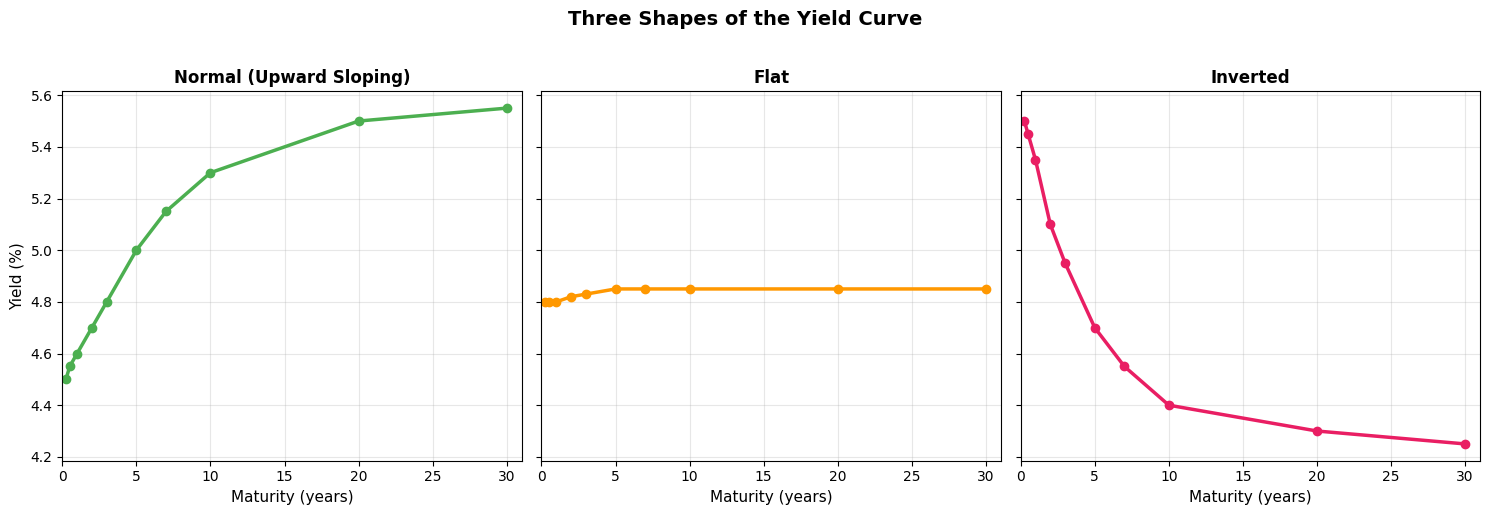

Normal curve: Investors demand higher rates for longer maturities (compensation for risk).
Inverted curve: Short-term rates exceed long-term rates (market expects rate cuts / recession).
Flat curve: No term premium — often a transition phase.


In [14]:
# Stage 8: Building and visualizing yield curves

# Typical yield curve shapes
maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])

# Normal (upward sloping) — the most common shape
normal_yields = np.array([4.50, 4.55, 4.60, 4.70, 4.80, 5.00, 5.15, 5.30, 5.50, 5.55]) / 100

# Inverted — historically signals recession
inverted_yields = np.array([5.50, 5.45, 5.35, 5.10, 4.95, 4.70, 4.55, 4.40, 4.30, 4.25]) / 100

# Flat — transition between normal and inverted
flat_yields = np.array([4.80, 4.80, 4.80, 4.82, 4.83, 4.85, 4.85, 4.85, 4.85, 4.85]) / 100

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, yields, title, color in [
    (axes[0], normal_yields, 'Normal (Upward Sloping)', '#4CAF50'),
    (axes[1], flat_yields, 'Flat', '#FF9800'),
    (axes[2], inverted_yields, 'Inverted', '#E91E63'),
]:
    ax.plot(maturities, yields * 100, 'o-', color=color, linewidth=2.5, markersize=6)
    ax.set_xlabel('Maturity (years)', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 31)

axes[0].set_ylabel('Yield (%)', fontsize=11)
fig.suptitle('Three Shapes of the Yield Curve', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Normal curve: Investors demand higher rates for longer maturities (compensation for risk).")
print("Inverted curve: Short-term rates exceed long-term rates (market expects rate cuts / recession).")
print("Flat curve: No term premium — often a transition phase.")

In [15]:
# What the yield curve means for bond pricing:
# The SAME bond gets different prices under different curves!

face = 1000
coupon_rate = 0.05

print(f"Bond: ${face:,} face, {coupon_rate:.0%} coupon, semi-annual\n")
print(f"{'Maturity':>10} {'Normal Yield':>13} {'Price (Normal)':>15} {'Inverted Yield':>15} {'Price (Inverted)':>17}")
print("-" * 73)

for i, mat in enumerate([1, 2, 3, 5, 7, 10]):
    # Find the closest maturity in our yield curve data
    idx = np.argmin(np.abs(maturities - mat))
    yn = normal_yields[idx]
    yi = inverted_yields[idx]
    pn = price_bond(face, coupon_rate, yn, mat)
    pi = price_bond(face, coupon_rate, yi, mat)
    print(f"{mat:>8}yr {yn:>12.2%} ${pn:>13,.2f} {yi:>14.2%} ${pi:>15,.2f}")

print(f"\nNotice: Under the inverted curve, long bonds are MORE expensive")
print(f"because the long-term discount rates are LOWER.")

Bond: $1,000 face, 5% coupon, semi-annual

  Maturity  Normal Yield  Price (Normal)  Inverted Yield  Price (Inverted)
-------------------------------------------------------------------------
       1yr        4.60% $     1,003.87          5.35% $         996.64
       2yr        4.70% $     1,005.66          5.10% $         998.12
       3yr        4.80% $     1,005.53          4.95% $       1,001.38
       5yr        5.00% $     1,000.00          4.70% $       1,013.23
       7yr        5.15% $       991.28          4.55% $       1,026.72
      10yr        5.30% $       976.94          4.40% $       1,048.12

Notice: Under the inverted curve, long bonds are MORE expensive
because the long-term discount rates are LOWER.


---
## Stage 9 — Spot Rates and Bootstrapping

### Motivation

YTM uses one flat rate for all cash flows of a bond. But we just saw that different
maturities have different rates! **Spot rates** are the "true" discount rates for each
specific maturity — and **bootstrapping** is how we extract them from observed bond prices.

### Intuition

Think of YTM as an *average* speed for a road trip. Spot rates are the speed at each
mile marker. Bootstrapping is like measuring those mile-by-mile speeds: you start with
the shortest bond (which has only one cash flow, so its rate IS the spot rate), then
use that to figure out the next rate, and so on.

In [16]:
# Stage 9: Bootstrapping spot rates from bond prices

# Suppose we observe these annual-coupon bonds:
# (maturity_years, coupon_rate, market_price) — all face = $1000
observed_bonds = [
    (1, 0.040, 997.00),   # 1-year bond
    (2, 0.045, 998.50),   # 2-year bond
    (3, 0.050, 1001.00),  # 3-year bond
    (4, 0.052, 999.00),   # 4-year bond
    (5, 0.055, 1002.50),  # 5-year bond
]

face = 1000
spot_rates = {}  # year -> spot rate

print("Bootstrapping spot rates from observed bond prices\n")
print(f"{'Bond':>6} {'Coupon':>8} {'Price':>10} {'Spot Rate':>12}")
print("-" * 40)

for mat, cpn_rate, price in observed_bonds:
    coupon = face * cpn_rate
    
    # Sum PV of all coupons before maturity using already-known spot rates
    pv_prior_coupons = 0.0
    for t in range(1, mat):
        pv_prior_coupons += coupon / (1 + spot_rates[t]) ** t
    
    # The last cash flow (coupon + face) discounted at the unknown spot rate
    # must equal: price - pv_prior_coupons
    last_cf = coupon + face
    remaining = price - pv_prior_coupons
    
    # Solve: remaining = last_cf / (1 + s)^mat
    # => (1 + s)^mat = last_cf / remaining
    # => s = (last_cf / remaining)^(1/mat) - 1
    s = (last_cf / remaining) ** (1.0 / mat) - 1
    spot_rates[mat] = s
    
    print(f"{mat:>4}yr {cpn_rate:>7.1%} ${price:>8,.2f} {s:>11.4%}")

print(f"\nBootstrapped spot rates:")
for t, s in sorted(spot_rates.items()):
    print(f"  Year {t}: {s:.4%}")

Bootstrapping spot rates from observed bond prices

  Bond   Coupon      Price    Spot Rate
----------------------------------------
   1yr    4.0% $  997.00     4.3129%
   2yr    4.5% $  998.50     4.5862%
   3yr    5.0% $1,001.00     4.9874%
   4yr    5.2% $  999.00     5.2689%
   5yr    5.5% $1,002.50     5.5011%

Bootstrapped spot rates:
  Year 1: 4.3129%
  Year 2: 4.5862%
  Year 3: 4.9874%
  Year 4: 5.2689%
  Year 5: 5.5011%


In [17]:
# Verify: re-price each bond using spot rates and compare to market

print("Verification: re-pricing bonds with bootstrapped spot rates\n")
print(f"{'Bond':>6} {'Market Price':>13} {'Spot-Rate Price':>16} {'Error':>10}")
print("-" * 48)

for mat, cpn_rate, market_price in observed_bonds:
    coupon = face * cpn_rate
    model_price = 0.0
    for t in range(1, mat):
        model_price += coupon / (1 + spot_rates[t]) ** t
    model_price += (coupon + face) / (1 + spot_rates[mat]) ** mat
    
    error = model_price - market_price
    print(f"{mat:>4}yr ${market_price:>11,.2f} ${model_price:>14,.2f} ${error:>8.4f}")

print(f"\nAll errors are essentially zero — the spot rates perfectly reprice the bonds.")

Verification: re-pricing bonds with bootstrapped spot rates

  Bond  Market Price  Spot-Rate Price      Error
------------------------------------------------
   1yr $     997.00 $        997.00 $  0.0000
   2yr $     998.50 $        998.50 $ -0.0000
   3yr $   1,001.00 $      1,001.00 $  0.0000
   4yr $     999.00 $        999.00 $  0.0000
   5yr $   1,002.50 $      1,002.50 $ -0.0000

All errors are essentially zero — the spot rates perfectly reprice the bonds.


---
## Stage 10 — Duration: Interest Rate Sensitivity

### Motivation

If interest rates change by 1%, how much does your bond price change? This is the most
important risk question in fixed income. The answer is **duration** — a measure of a bond's
sensitivity to rate changes.

### Intuition

Duration is the *weighted average time* until you get your money back, where the weights
are the present values of each cash flow. A bond with higher duration is like a longer
lever — small rate moves create big price swings. A zero-coupon bond has the highest
duration (all your money comes back at once, at the end). A high-coupon bond has lower
duration (you get money back sooner via coupons).

In [18]:
# Stage 10: Macaulay duration and modified duration

def bond_duration(face_value, coupon_rate, yield_rate, years, freq=2):
    """Calculate Macaulay and Modified duration.
    
    Returns: (macaulay_duration, modified_duration, price)
    """
    n_periods = int(years * freq)
    coupon = face_value * coupon_rate / freq
    y = yield_rate / freq
    
    price = 0.0
    weighted_time = 0.0
    
    for t in range(1, n_periods + 1):
        cf = coupon if t < n_periods else coupon + face_value
        pv = cf / (1 + y) ** t
        price += pv
        weighted_time += (t / freq) * pv  # time in years * PV
    
    macaulay = weighted_time / price
    modified = macaulay / (1 + y)
    
    return macaulay, modified, price

# Compare durations of different bonds
face = 1000
yield_rate = 0.05

print(f"Duration comparison (all yields = {yield_rate:.0%}, semi-annual)\n")
print(f"{'Bond':>25} {'Mac. Duration':>14} {'Mod. Duration':>14} {'Price':>10}")
print("-" * 66)

bonds = [
    ("2yr, 5% coupon",  0.05, 2),
    ("5yr, 5% coupon",  0.05, 5),
    ("10yr, 5% coupon", 0.05, 10),
    ("30yr, 5% coupon", 0.05, 30),
    ("10yr, 2% coupon", 0.02, 10),
    ("10yr, 8% coupon", 0.08, 10),
    ("10yr, 0% coupon", 0.00, 10),  # zero coupon
]

for label, cpn, yrs in bonds:
    mac, mod, p = bond_duration(face, cpn, yield_rate, yrs)
    print(f"{label:>25} {mac:>12.2f}yr {mod:>12.2f}yr ${p:>8,.2f}")

print(f"\nKey observations:")
print(f"  1. Longer maturity → higher duration (more rate sensitivity)")
print(f"  2. Lower coupon → higher duration (less cash flow before maturity)")
print(f"  3. Zero-coupon bond: duration = maturity (all cash at the end)")

Duration comparison (all yields = 5%, semi-annual)

                     Bond  Mac. Duration  Mod. Duration      Price
------------------------------------------------------------------
           2yr, 5% coupon         1.93yr         1.88yr $1,000.00
           5yr, 5% coupon         4.49yr         4.38yr $1,000.00
          10yr, 5% coupon         7.99yr         7.79yr $1,000.00
          30yr, 5% coupon        15.84yr        15.45yr $1,000.00
          10yr, 2% coupon         8.95yr         8.73yr $  766.16
          10yr, 8% coupon         7.39yr         7.21yr $1,233.84
          10yr, 0% coupon        10.00yr         9.76yr $  610.27

Key observations:
  1. Longer maturity → higher duration (more rate sensitivity)
  2. Lower coupon → higher duration (less cash flow before maturity)
  3. Zero-coupon bond: duration = maturity (all cash at the end)


In [19]:
# Empirical verification: does duration correctly predict price changes?

face = 1000
coupon_rate = 0.05
years = 10
base_yield = 0.05

mac_dur, mod_dur, base_price = bond_duration(face, coupon_rate, base_yield, years)

print(f"10-year, 5% coupon bond at 5% yield")
print(f"Price: ${base_price:,.2f}, Modified Duration: {mod_dur:.4f} years\n")

# Duration approximation: dP/P ≈ -ModDur × dy
print(f"{'Yield Change':>13} {'Actual Price':>13} {'Duration Est.':>14} {'Error':>10}")
print("-" * 53)

for dy in [-0.02, -0.01, -0.005, 0.005, 0.01, 0.02]:
    actual_price = price_bond(face, coupon_rate, base_yield + dy, years)
    # Duration approximation
    est_price = base_price * (1 - mod_dur * dy)
    error = est_price - actual_price
    print(f"{dy:>+12.1%} ${actual_price:>11,.2f} ${est_price:>12,.2f} ${error:>8,.2f}")

print(f"\nDuration is a good approximation for small rate changes.")
print(f"For larger changes, the error grows (this is 'convexity' — a second-order effect).")

10-year, 5% coupon bond at 5% yield
Price: $1,000.00, Modified Duration: 7.7946 years

 Yield Change  Actual Price  Duration Est.      Error
-----------------------------------------------------
       -2.0% $   1,171.69 $    1,155.89 $  -15.79
       -1.0% $   1,081.76 $    1,077.95 $   -3.81
       -0.5% $   1,039.91 $    1,038.97 $   -0.94
       +0.5% $     961.93 $      961.03 $   -0.90
       +1.0% $     925.61 $      922.05 $   -3.56
       +2.0% $     857.88 $      844.11 $  -13.77

Duration is a good approximation for small rate changes.
For larger changes, the error grows (this is 'convexity' — a second-order effect).


---
## Stage 11 — Putting It All Together: A Mini Bond Analytics Engine

### Motivation

We've built all the pieces. Now let's combine them into a clean, reusable class that does
everything: pricing, YTM, duration, and scenario analysis.

### Intuition

Think of this as graduating from individual tools (hammer, saw, drill) to a complete
workbench. Each method corresponds to a concept we built from scratch.

In [20]:
# Stage 11: Production-quality BondAnalytics class

class Bond:
    """A fixed-rate bond with all the analytics we've built."""
    
    def __init__(self, face_value=1000, coupon_rate=0.05, years=10, freq=2):
        self.face_value = face_value
        self.coupon_rate = coupon_rate
        self.years = years
        self.freq = freq
        self.n_periods = int(years * freq)
        self.coupon = face_value * coupon_rate / freq
    
    def cash_flows(self):
        """Return list of (time_in_years, cash_flow) tuples."""
        flows = []
        for t in range(1, self.n_periods + 1):
            cf = self.coupon if t < self.n_periods else self.coupon + self.face_value
            flows.append((t / self.freq, cf))
        return flows
    
    def price(self, yield_rate):
        """Price the bond at a given yield."""
        y = yield_rate / self.freq
        total = 0.0
        for t in range(1, self.n_periods + 1):
            cf = self.coupon if t < self.n_periods else self.coupon + self.face_value
            total += cf / (1 + y) ** t
        return total
    
    def ytm(self, market_price, tol=1e-10):
        """Find yield to maturity given market price."""
        lo, hi = 0.0001, 1.0
        for _ in range(500):
            mid = (lo + hi) / 2
            p = self.price(mid)
            if abs(p - market_price) < tol:
                return mid
            if p > market_price:
                lo = mid
            else:
                hi = mid
        return mid
    
    def duration(self, yield_rate):
        """Calculate Macaulay and Modified duration."""
        y = yield_rate / self.freq
        price = 0.0
        weighted = 0.0
        for t in range(1, self.n_periods + 1):
            cf = self.coupon if t < self.n_periods else self.coupon + self.face_value
            pv = cf / (1 + y) ** t
            price += pv
            weighted += (t / self.freq) * pv
        macaulay = weighted / price
        modified = macaulay / (1 + y)
        return macaulay, modified
    
    def convexity(self, yield_rate):
        """Calculate convexity (second-order rate sensitivity)."""
        y = yield_rate / self.freq
        price = 0.0
        conv_sum = 0.0
        for t in range(1, self.n_periods + 1):
            cf = self.coupon if t < self.n_periods else self.coupon + self.face_value
            pv = cf / (1 + y) ** t
            price += pv
            # Convexity uses t*(t+1) weighting
            conv_sum += pv * t * (t + 1)
        return conv_sum / (price * self.freq**2 * (1 + y)**2)
    
    def price_change_estimate(self, yield_rate, dy):
        """Estimate price change using duration + convexity."""
        _, mod_dur = self.duration(yield_rate)
        conv = self.convexity(yield_rate)
        p = self.price(yield_rate)
        # Second-order Taylor approximation
        dp = -mod_dur * dy + 0.5 * conv * dy**2
        return p * dp
    
    def scenario_analysis(self, base_yield, yield_shocks):
        """Run scenario analysis across yield shocks."""
        base_price = self.price(base_yield)
        results = []
        for dy in yield_shocks:
            new_yield = base_yield + dy
            actual_price = self.price(new_yield)
            est_change = self.price_change_estimate(base_yield, dy)
            results.append({
                'shock': dy,
                'new_yield': new_yield,
                'actual_price': actual_price,
                'actual_change': actual_price - base_price,
                'estimated_change': est_change,
            })
        return results
    
    def __repr__(self):
        return (f"Bond(face={self.face_value}, coupon={self.coupon_rate:.1%}, "
                f"years={self.years}, freq={self.freq})")


# Demo: full analytics on a bond
bond = Bond(face_value=1000, coupon_rate=0.05, years=10, freq=2)
yield_rate = 0.06

print(f"Bond: {bond}")
print(f"Yield: {yield_rate:.0%}")
print(f"")
print(f"Price:              ${bond.price(yield_rate):>10,.2f}")
mac, mod = bond.duration(yield_rate)
print(f"Macaulay Duration:  {mac:>10.4f} years")
print(f"Modified Duration:  {mod:>10.4f} years")
print(f"Convexity:          {bond.convexity(yield_rate):>10.4f}")
print(f"")

# Reverse: from price back to yield
p = bond.price(yield_rate)
recovered_ytm = bond.ytm(p)
print(f"Reverse check: price ${p:,.2f} → YTM = {recovered_ytm:.6%}")
assert abs(recovered_ytm - yield_rate) < 1e-6
print(f"Round-trip verified.")

Bond: Bond(face=1000, coupon=5.0%, years=10, freq=2)
Yield: 6%

Price:              $    925.61
Macaulay Duration:      7.8950 years
Modified Duration:      7.6650 years
Convexity:             71.7854

Reverse check: price $925.61 → YTM = 6.000000%
Round-trip verified.


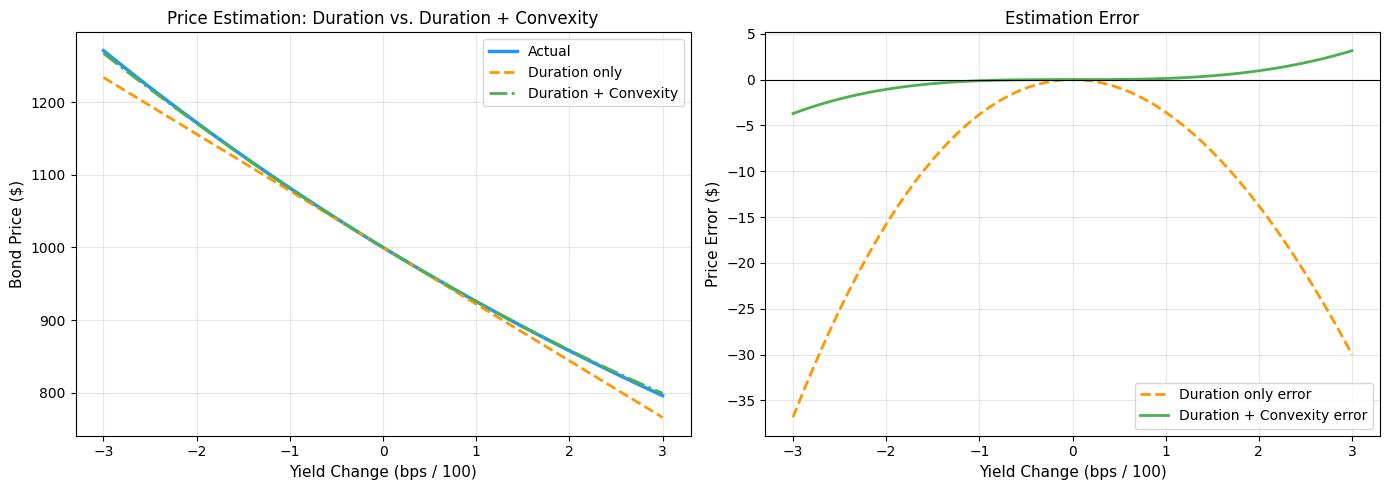

Duration alone underestimates price on both sides (the curve is convex).
Adding convexity dramatically reduces the estimation error.


In [21]:
# Scenario analysis: duration + convexity vs. actual price change

bond = Bond(face_value=1000, coupon_rate=0.05, years=10, freq=2)
base_yield = 0.05
base_price = bond.price(base_yield)

shocks = np.linspace(-0.03, 0.03, 61)
actual_prices = [bond.price(base_yield + dy) for dy in shocks]
duration_est = [base_price + bond.price_change_estimate(base_yield, dy) for dy in shocks]

# Duration-only estimate (no convexity) for comparison
_, mod_dur = bond.duration(base_yield)
dur_only_est = [base_price * (1 - mod_dur * dy) for dy in shocks]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Price comparison
ax1.plot(shocks * 100, actual_prices, '-', color='#2196F3', linewidth=2.5, label='Actual')
ax1.plot(shocks * 100, dur_only_est, '--', color='#FF9800', linewidth=2, label='Duration only')
ax1.plot(shocks * 100, duration_est, '-.', color='#4CAF50', linewidth=2, label='Duration + Convexity')
ax1.set_xlabel('Yield Change (bps / 100)', fontsize=11)
ax1.set_ylabel('Bond Price ($)', fontsize=11)
ax1.set_title('Price Estimation: Duration vs. Duration + Convexity', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Error comparison
dur_error = [d - a for d, a in zip(dur_only_est, actual_prices)]
conv_error = [d - a for d, a in zip(duration_est, actual_prices)]
ax2.plot(shocks * 100, dur_error, '--', color='#FF9800', linewidth=2, label='Duration only error')
ax2.plot(shocks * 100, conv_error, '-', color='#4CAF50', linewidth=2, label='Duration + Convexity error')
ax2.axhline(y=0, color='black', linewidth=0.8)
ax2.set_xlabel('Yield Change (bps / 100)', fontsize=11)
ax2.set_ylabel('Price Error ($)', fontsize=11)
ax2.set_title('Estimation Error', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Duration alone underestimates price on both sides (the curve is convex).")
print("Adding convexity dramatically reduces the estimation error.")

In [22]:
# Benchmark: how fast is our bond pricer?

import time

bond = Bond(face_value=1000, coupon_rate=0.05, years=30, freq=2)

# Benchmark pricing
n_iterations = 50_000
start = time.perf_counter()
for _ in range(n_iterations):
    bond.price(0.05)
elapsed_price = time.perf_counter() - start

# Benchmark YTM
n_ytm = 5_000
start = time.perf_counter()
for _ in range(n_ytm):
    bond.ytm(950)
elapsed_ytm = time.perf_counter() - start

# Benchmark full analytics
n_full = 5_000
start = time.perf_counter()
for _ in range(n_full):
    bond.price(0.05)
    bond.duration(0.05)
    bond.convexity(0.05)
elapsed_full = time.perf_counter() - start

print(f"Bond: 30-year, semi-annual (60 periods)\n")
print(f"{'Operation':<25} {'Iterations':>12} {'Total (s)':>10} {'Per call':>12}")
print("-" * 62)
print(f"{'Price'::<25} {n_iterations:>12,} {elapsed_price:>10.3f} {elapsed_price/n_iterations*1e6:>9.1f} us")
print(f"{'YTM (bisection)'::<25} {n_ytm:>12,} {elapsed_ytm:>10.3f} {elapsed_ytm/n_ytm*1e6:>9.1f} us")
print(f"{'Full analytics'::<25} {n_full:>12,} {elapsed_full:>10.3f} {elapsed_full/n_full*1e6:>9.1f} us")
print(f"\nPure Python, no NumPy — fast enough for interactive use.")
print(f"For production at scale, you'd vectorize with NumPy or use C extensions.")

Bond: 30-year, semi-annual (60 periods)

Operation                   Iterations  Total (s)     Per call
--------------------------------------------------------------
Price::::::::::::::::::::       50,000      0.267       5.3 us
YTM (bisection)::::::::::        5,000      1.216     243.1 us
Full analytics:::::::::::        5,000      0.099      19.8 us

Pure Python, no NumPy — fast enough for interactive use.
For production at scale, you'd vectorize with NumPy or use C extensions.


---
## Stage 12 — Key Takeaways and Practice Exercises

### The Generalizable Pattern

Everything in this notebook flows from one operation: **multiply by (1+r) to go forward,
divide by (1+r) to go backward.** Once you have that, the rest is just applying it to
different cash flow patterns:

| Concept | What it really is |
|---------|------------------|
| Compound interest | FV = PV * (1+r)^n |
| Discounting | PV = FV / (1+r)^n |
| NPV | Sum of PV(each cash flow) |
| Bond price | NPV of coupon stream + face value |
| YTM | The rate that makes NPV = market price |
| Spot rate | The "true" rate for a specific maturity |
| Duration | How sensitive NPV is to rate changes |

### Key Takeaways

1. **Time is money — literally.** A dollar today is worth more than a dollar tomorrow by exactly the discount factor.
2. **Discounting is the universal translator** for comparing cash flows at different times.
3. **Bond pricing is just NPV** with a structured set of cash flows.
4. **YTM and IRR are the same concept** — the rate that makes NPV equal zero (or equal to the price).
5. **Duration measures risk** — how much your bond portfolio moves when rates change.
6. **The yield curve tells a story** — its shape reflects market expectations about future rates.

In [23]:
# Final summary: all concepts in one table

print("=" * 70)
print("SUMMARY: Present Value and Discounting — The Complete Picture")
print("=" * 70)
print()

concepts = [
    ("Compound Interest", "FV = PV * (1+r)^n", "How money grows over time"),
    ("Discount Factor",   "DF = 1/(1+r)^n",    "Exchange rate: future $ to today's $"),
    ("Present Value",     "PV = FV * DF",       "Fair price of a future payment"),
    ("NPV",              "Sum(PV_i)",           "Total value of a cash flow stream"),
    ("IRR",              "NPV(IRR) = 0",        "Breakeven discount rate"),
    ("Bond Price",       "NPV(coupons + face)", "Market value of a debt instrument"),
    ("YTM",              "Price = NPV(YTM)",    "Bond's implied return if held to maturity"),
    ("Spot Rate",        "Bootstrapped",        "True rate for a single maturity"),
    ("Duration",         "dP/P = -D*dy",       "Price sensitivity to rate changes"),
    ("Convexity",        "d2P/P = C*dy^2",     "Curvature of price-yield relationship"),
]

print(f"{'Concept':<20} {'Formula':<22} {'Meaning'}")
print("-" * 70)
for concept, formula, meaning in concepts:
    print(f"{concept:<20} {formula:<22} {meaning}")

print()
print("All of these are applications of ONE idea:")
print("  multiply by (1+r) to go forward, divide by (1+r) to go backward.")
print()
print("=" * 70)

SUMMARY: Present Value and Discounting — The Complete Picture

Concept              Formula                Meaning
----------------------------------------------------------------------
Compound Interest    FV = PV * (1+r)^n      How money grows over time
Discount Factor      DF = 1/(1+r)^n         Exchange rate: future $ to today's $
Present Value        PV = FV * DF           Fair price of a future payment
NPV                  Sum(PV_i)              Total value of a cash flow stream
IRR                  NPV(IRR) = 0           Breakeven discount rate
Bond Price           NPV(coupons + face)    Market value of a debt instrument
YTM                  Price = NPV(YTM)       Bond's implied return if held to maturity
Spot Rate            Bootstrapped           True rate for a single maturity
Duration             dP/P = -D*dy           Price sensitivity to rate changes
Convexity            d2P/P = C*dy^2         Curvature of price-yield relationship

All of these are applications of ONE idea

### Practice Exercises

**Exercise 1: Zero-Coupon Bond Pricing**

A zero-coupon bond pays no coupons — just the face value at maturity.
- Price a $1,000 zero-coupon bond with 5 years to maturity at yields of 3%, 5%, and 8%.
- Calculate the duration of each. What pattern do you notice?
- Hint: The `Bond` class already handles `coupon_rate=0.0`.

**Exercise 2: Comparing Two Investments**

You're choosing between:
- **Option A:** Pay $10,000 today, receive $3,000/year for 5 years.
- **Option B:** Pay $10,000 today, receive $1,500/year for 12 years.

Which is better at a 6% discount rate? At what rate are they equivalent?
Use the `npv()` and `irr_bisection()` functions from earlier.

**Exercise 3: Yield Curve Impact**

Using the `Bond` class, price a portfolio of three bonds (2yr, 10yr, 30yr, all 4% coupon)
under the normal and inverted yield curves from Stage 8. Which portfolio is more sensitive
to the curve shape? Why?

In [24]:
# Exercise starters (uncomment and fill in)

# --- Exercise 1 ---
# zero_bond = Bond(face_value=1000, coupon_rate=0.0, years=5, freq=2)
# for y in [0.03, 0.05, 0.08]:
#     p = zero_bond.price(y)
#     mac, mod = zero_bond.duration(y)
#     print(f"Yield={y:.0%}: Price=${p:,.2f}, Duration={mac:.2f}yr")

# --- Exercise 2 ---
# option_a = [(0, -10000)] + [(t, 3000) for t in range(1, 6)]
# option_b = [(0, -10000)] + [(t, 1500) for t in range(1, 13)]
# print(f"NPV(A) at 6% = ${npv(0.06, option_a):,.2f}")
# print(f"NPV(B) at 6% = ${npv(0.06, option_b):,.2f}")

print("Exercises ready — uncomment the code above and try them!")
print("Each exercise builds on functions and classes from earlier stages.")

Exercises ready — uncomment the code above and try them!
Each exercise builds on functions and classes from earlier stages.
